In [64]:
import pymodels as pm
import pyaccel as pa
import numpy as np
import matplotlib.pyplot as plt
from auxiliar_scripts.nlk import si_nlk_kick
from mathphys.beam_optics import beam_rigidity
from scipy.optimize import minimize

In [65]:
plt.style.use(['notebook'])

In [66]:
fig_path = r'/home/jucelio/notebooks/figures/TS_effects_on_exchange/'

# Useful functions

In [67]:
def compute_emittances(bunch, local_twiss):
    """."""
    twiss = local_twiss
    etax, etapx = twiss.etax, twiss.etapx
    etay, etapy = twiss.etay, twiss.etapy
    disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
    bunch_nodisp = bunch - bunch[4]*disp
    emitx = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[0:2, :])))
    emity = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4, :])))
    
    return emitx, emity

In [68]:
def plot_phases_diagrams(bunch, bunch_ex, emitx, emity, emitx_ex, emity_ex, title=""):
    fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=False, sharey=False)
    x, x_ = bunch[0, :]*1e3, bunch[1, :]*1e3
    y, y_ = bunch[2, :]*1e3, bunch[3, :]*1e3
    x_ex, x__ex = bunch_ex[0, :]*1e3, bunch_ex[1, :]*1e3
    y_ex, y__ex = bunch_ex[2, :]*1e3, bunch_ex[3, :]*1e3

    ax[0].scatter(x, x_, s=2, label=r'$\epsilon_x = {:.3f} nm$'.format(emitx*1e9), alpha=1, color='tab:blue')
    ax[0].scatter(x_ex, x__ex, s=2, label=r'$\epsilon_x (exchanged) = {:.3f} nm$'.format(emitx_ex*1e9), 
                  color='tab:red', alpha=1)

    ax[1].scatter(y_ex, y__ex, s=2, label=r'$\epsilon_y (exchanged) = {:.3f} nm$'.format(emity_ex*1e9),
                  color='tab:red', alpha=1)
    ax[1].scatter(y, y_, s=2, label=r'$\epsilon_y = {:.2f} nm$'.format(emity*1e9), alpha=1, color='tab:blue')


    fig.suptitle(title, fontsize=16)
    ax[0].set_xlabel('x [mm]')
    ax[0].set_ylabel("x' [mrad]")
    ax[1].set_xlabel('y [mm]')
    ax[1].set_ylabel("y' [mrad]")
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
#     plt.tight_layout()
#     plt.savefig(fname,dpi=160)
    return fig, ax
    #     plt.show()

In [129]:
def error_func(bunch, gain, LPolyB_nom, nlk_l=0.45):
    # Setting NLK for the beam aways be in x'= 0 after the kick
    nlk_si[0].polynom_b = gain*LPolyB_nom[0]/nlk_l

    # Tracking beam through NLK
    part_out_ex, *_ = pa.tracking.line_pass(nlk_si,
                                            bunch, indices='closed',
                                            parallel=True)
    if bunch.ndim < 3:
        bunch_final = part_out_ex[:,-1]
    else:
        bunch_final = part_out_ex[:,:,-1]
    x__ = bunch_final[1].mean()
    return np.abs(x__)

In [126]:
bunch.ndim

1

# Bunch at Booster end - TS beginning

In [70]:
# Creating a booster with small coupling
bo = pm.bo.create_accelerator(energy=3e9)
bo_famdata = pm.bo.get_family_data(bo)
bo.radiation_on = True
bo.vchamber_on = True
bo.cavity_on = True
KsL = -0.015
qs_idx = bo_famdata['QS']['index']
bo[qs_idx[0][0]].KsL = KsL

# Creating the TS line
ts, ts_init_twiss = pm.ts.create_accelerator(
                    optics_mode="M2")  # Maybe is better change to "M2"
ts.radiation_on = True
ts.vchamber_on = True

Creating the bunch

In [71]:
bo_eqparam = pa.optics.EqParamsFromBeamEnvelope(accelerator=bo)
emit1 = bo_eqparam.emit1
emit2 = bo_eqparam.emit2
sigme = bo_eqparam.espread0
sigmal = bo_eqparam.bunlen
n_part = 5000

# Supposing a emittance exchange with R=0.95
R = 0.95
deltaemit = emit1-emit2
emit1_ex = emit1 - deltaemit*R
emit2_ex = emit2 + deltaemit*R

bunch = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1, emit2=emit2, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)
bunch_ex = pa.tracking.generate_bunch(n_part=n_part, emit1=emit1_ex, emit2=emit2_ex, 
                                   sigmae=sigme, sigmas=sigmal, optics=ts_init_twiss)

Computing emittances

In [72]:
# Shifting the bunch to the TS orbit
# centroid_at_ts =  np.array([2.73724778e-03,  4.25220469e-04, -7.24359070e-21,  3.19401356e-21,
#  -7.96083635e-05, -8.05961219e-02])
centroid_at_ts = np.array([0,0,0,0,0,0])
bunch = bunch + centroid_at_ts[:, None]
bunch_ex = bunch_ex + centroid_at_ts[:, None]

emitx, emity = compute_emittances(bunch, ts_init_twiss)
emitx_ex, emity_ex = compute_emittances(bunch_ex, ts_init_twiss)

Phase diagram

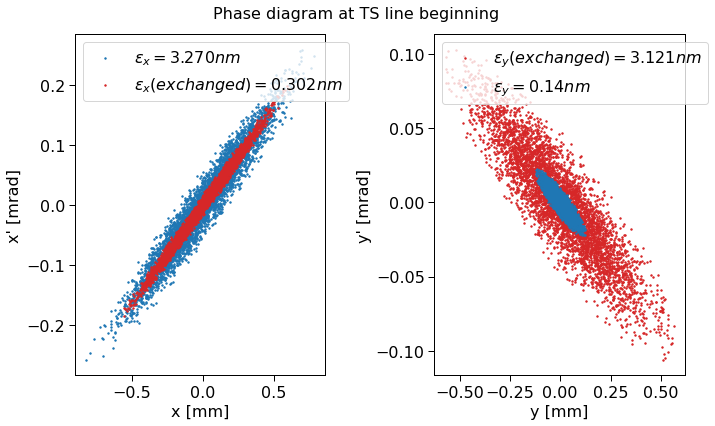

In [73]:
fname =  fname=fig_path+"before_ts.jpg"

fig, ax = plot_phases_diagrams(
    bunch, bunch_ex, emitx, emity,
    emitx_ex, emity_ex, title='Phase diagram at TS line beginning')
plt.tight_layout()
plt.savefig(fname,dpi=160)
plt.show()

Beam in horizontal and vertical coordinates

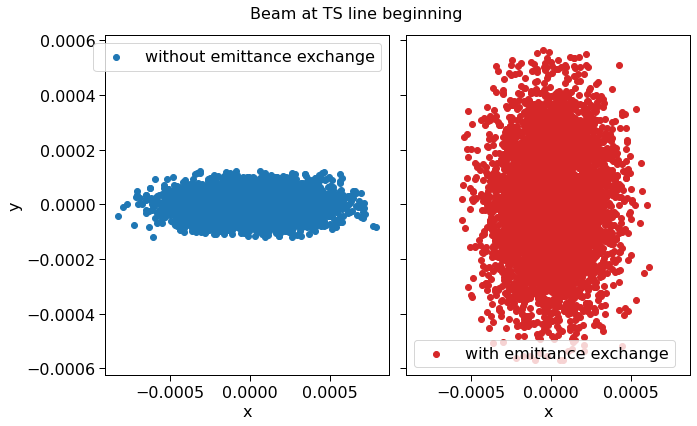

In [74]:
x, y = bunch[0, :], bunch[2, :]
x_ex, y_ex = bunch_ex[0, :], bunch_ex[2, :]

fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at TS line beginning', fontsize=16)

ax[0].scatter(x,y, label = 'without emittance exchange')
ax[1].scatter(x_ex, y_ex, color='tab:red', label='with emittance exchange')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig("beam_size_before.jpg", dpi=160)

# TS Tracking

In [75]:
# Passing through TS
part_out, lost_flag, *_ = pa.tracking.line_pass(
            ts, bunch, indices='closed'
            )
part_out_ex, lost_flag_ex, *_ = pa.tracking.line_pass(
            ts, bunch_ex, indices='closed'
            )

In [76]:
bunch_end = part_out[:, :, -1]
bunch_ex_end = part_out_ex[:, :, -1]

Computing emittances at the end of TS line

In [77]:
twi, *_ = pa.optics.calc_twiss(accelerator=ts, init_twiss=ts_init_twiss)
twiss = twi[-1]
# Without emittance exchange
emitx, emity =compute_emittances(bunch_end, twiss)
# With emittance exchange
emit1_ex, emit2_ex = compute_emittances(bunch_ex_end, twiss)

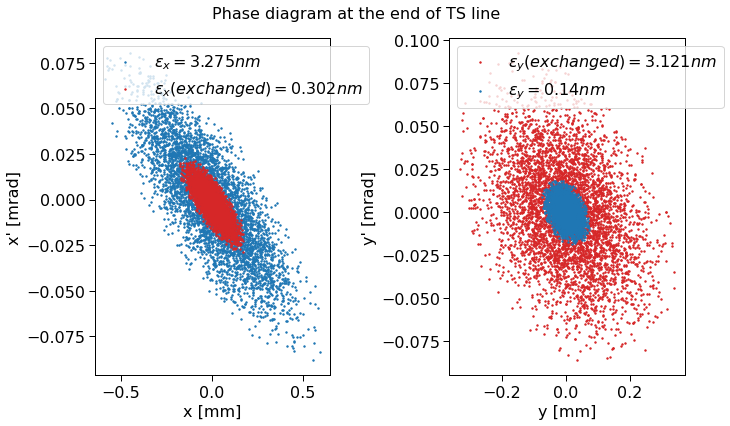

In [78]:
fname = fig_path + "before_ts.jpg"
plot_phases_diagrams(bunch_end, bunch_ex_end, emitx, emity,
                    emitx_ex, emity_ex, title='Phase diagram at the end of TS line')
plt.tight_layout()
plt.savefig(fname,dpi=160)
plt.show()

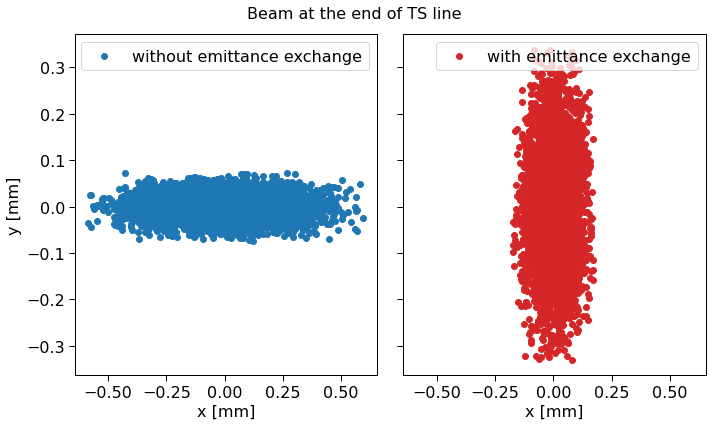

In [79]:
x, y = bunch_end[0, :], bunch_end[2, :]
x_ex, y_ex = bunch_ex_end[0, :], bunch_ex_end[2, :]

fig, ax = plt.subplots(1,2, figsize = (10,6), sharex=True, sharey=True)
fig.suptitle('Beam at the end of TS line ', fontsize=16)

ax[0].scatter(x*1e3, y*1e3, label = 'without emittance exchange')
ax[1].scatter(x_ex*1e3, y_ex*1e3, color='tab:red', label='with emittance exchange')
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[1].set_xlabel('x [mm]')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig("beam_after.jpg", dpi=160)

# NLK effect on the exchanged beam

## Transporting the beam until nlk

Creating Sirius, getting family data and changing the bunch reference frame

In [80]:
si = pm.si.create_accelerator()
si.cavity_on = True
si.radiation_on = True
si.vchamber_on = True

twi, _ = pa.optics.calc_twiss(si)
famdata = pm.si.get_family_data(si)
nlk_idx = famdata['InjNLKckr']['index']
sept_idx = pa.lattice.find_indices(
            lattice=si, attribute_name='fam_name', value='InjSeptF')
offset = np.array([-17.35e-3, 2.4e-3, 0, 0, 0, 0])[:, None]

bunch_sept = bunch_end - bunch_end.mean(axis=1)[:, None] + offset
bunchex_sept = bunch_ex_end - bunch_end.mean(axis=1)[:, None] +  offset

Tracking from Septa to NLK 

In [81]:
bunch_nlk, *_ = pa.tracking.line_pass(
    si, particles=bunch_sept, indices=nlk_idx[0], element_offset=sept_idx[0], parallel=True)

bunchex_nlk, *_ = pa.tracking.line_pass(
    si, particles=bunchex_sept, indices=nlk_idx[0], element_offset=sept_idx[0], parallel=True)

emitx, emity = compute_emittances(bunch_nlk, twi[nlk_idx[0][0]])
emitx_ex, emity_ex = compute_emittances(bunchex_nlk, twi[nlk_idx[0][0]])

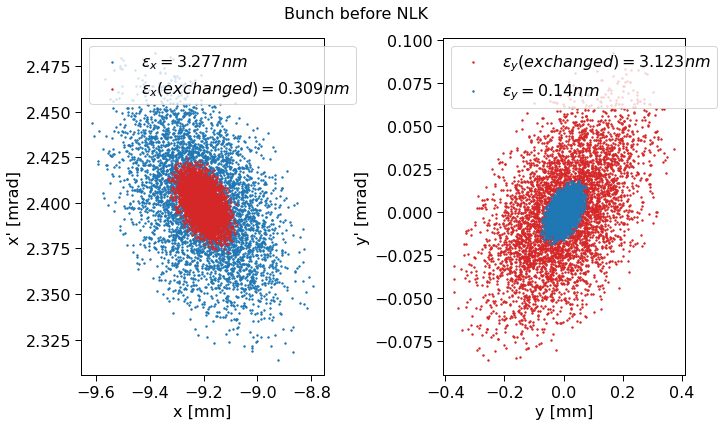

In [82]:
fig, ax = plot_phases_diagrams(
            bunch_nlk, bunchex_nlk, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch before NLK')
plt.tight_layout()
plt.show()

## Kicking the beam

Putting the bunch at NLK based on offset values available on Wiki-Sirius

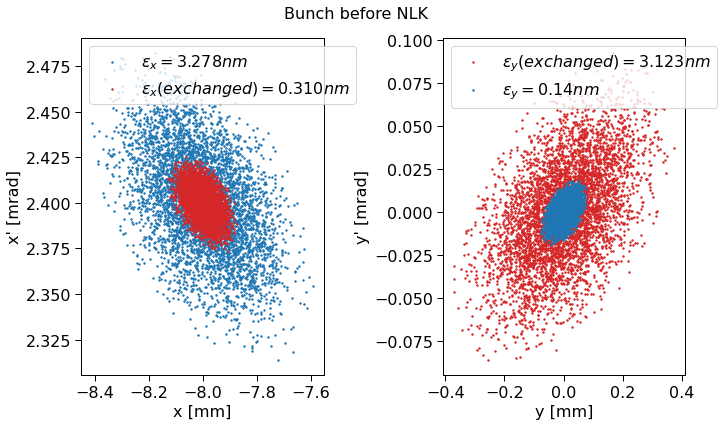

In [159]:
nlk_b_offset = np.array([-8e-3, 2.4e-3, 0, 0, 0, 0])[:, None] # Bunch offset at NLK
bunch_nlk += nlk_b_offset - bunch_nlk.mean(axis=1)[:, None]
bunchex_nlk += nlk_b_offset - bunchex_nlk.mean(axis=1)[:, None]

fig, ax = plot_phases_diagrams(
            bunch_nlk, bunchex_nlk, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch before NLK')
plt.tight_layout()
plt.show()

In [160]:
bunch_nlk.mean(axis=1)

array([-8.00000000e-03,  2.40000000e-03, -4.77048956e-22,  9.48676901e-23,
        1.24900090e-20,  1.72084569e-19])

Loading the nlk profile

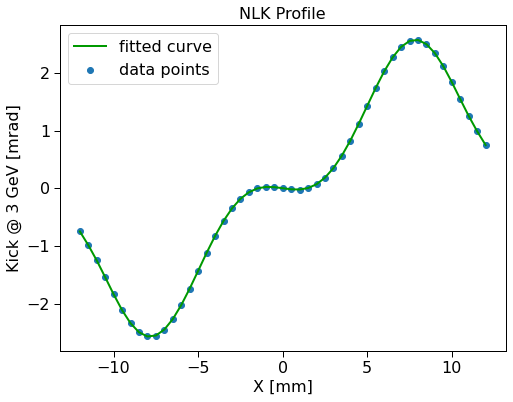

In [161]:
monomials = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])[None, :]
_, _, kickx, LPolyB_nominal = si_nlk_kick(plot_flag=True, strength=0.27358145, fit_monomials=monomials)
plt.show()

Minimizing x' with scipy using k as parameter

In [162]:
fun = lambda k: error_func(bunchex_nlk, k, LPolyB_nominal, nlk_l=0.45)
res = minimize(fun, 1, tol=1e-6)

In [175]:
res

      fun: 1.0047010966240943e-12
 hess_inv: array([[352.56968636]])
      jac: array([0.00115568])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 146
      nit: 1
     njev: 67
   status: 2
  success: False
        x: array([1.86406822])

Setting the NLK pulse

In [172]:
nlk_l = si[nlk_idx[0][0]].length
si[nlk_idx[0][0]].polynom_b = res.x[0]*LPolyB_nominal[0]/nlk_l
# si[nlk_idx[0][0]].polynom_b = LPolyB_nominal[0]/nlk_l

Bunch after NLK

In [173]:
nlk_si = si[nlk_idx[0][0]:nlk_idx[0][0]+1]

part_out, *_ = pa.tracking.line_pass(nlk_si, bunch_nlk, indices='closed', parallel=True)

part_out_ex, *_ = pa.tracking.line_pass(nlk_si, bunchex_nlk, indices='closed', parallel=True)

bunch_final = part_out[:,:,-1]
bunchex_final = part_out_ex[:,:,-1]

# Emittances after NLK
si_twi, _ = pa.optics.calc_twiss(si)
emitx, emity = compute_emittances(bunch_final, si_twi[0])
emitx_ex, emity_ex = compute_emittances(bunchex_final, si_twi[0])

In [174]:
bunch_final.mean(axis=1)

array([-7.99864355e-03, -2.39405027e-03,  8.88014186e-09,  3.98544318e-08,
       -1.94146344e-08,  4.31118372e-07])

Disable NLK

In [165]:
si[nlk_idx[0][0]].polynom_b = np.zeros([7])

Computing acceptances

In [166]:
si.radiation_on = False
particle = np.array([-7.5e-3, 0, 0, 0, 0, 0])[:, None]
particle2 = np.array([-8e-3, 0, 0, 0, 0, 0])[:, None]
particle3 = np.array([-8.5e-3, 0, 0, 0, 0, 0])[:, None]
particle4 = np.array([-9e-3, 0, 0, 0, 0, 0])[:, None]
particles = np.array([particle, particle2, particle3, particle4])[:,:, 0].T

part_out, *_ = pa.tracking.ring_pass(
    si, particles, parallel=True, nr_turns = 2000, 
    turn_by_turn=True)
si.radiation_on = True

apert = part_out.copy()

Plotting bunch with acceptances

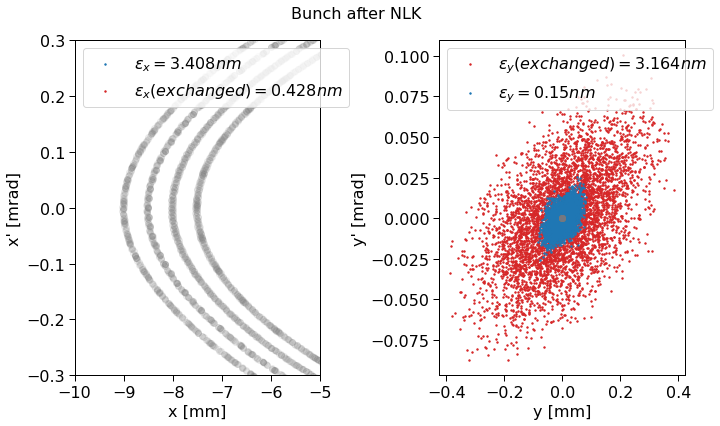

In [167]:
fig, ax = plot_phases_diagrams(
            bunch_final, bunchex_final, emitx, emity, 
            emitx_ex, emity_ex, title='Bunch after NLK')
ax[0].scatter(apert[0]*1e3, apert[1]*1e3, alpha=0.1, c='tab:gray')
ax[1].scatter(apert[2]*1e3, apert[3]*1e3, alpha=0.1, c='tab:gray')

ax[0].set_xlim([-10, -5])
ax[0].set_ylim([-0.3, 0.3])
plt.tight_layout()
plt.show()

In [169]:
bunch_final.mean(axis=1)

array([-7.99864355e-03, -2.39405027e-03,  8.88014186e-09,  3.98544318e-08,
       -1.94146344e-08,  4.31118372e-07])

## Testing different initial offsets at NLK beginning

Creating bunchs in different positions at NLK

In [139]:
nlk_id = nlk_idx[0][0]
x_list = np.linspace(-9, -7,num=5)*1e-3
bunchs_before = np.zeros([x_list.size, 6, n_part])
bunchs_after = bunchs_before.copy()
bunchsex_before = np.zeros([x_list.size, 6, n_part])
bunchsex_after = bunchs_before.copy()

for n in range(bunchs_before.shape[0]):
    bunchs_before[n] = bunch_nlk.copy()
    bunchs_before[n][0] += -bunchs_before[n][0].mean() + x_list[n]
    
    bunchsex_before[n] = bunchex_nlk.copy()
    bunchsex_before[n][0] += -bunchsex_before[n][0].mean() + x_list[n]

Optimizing the NLK using macroparticles

In [140]:
ks = np.zeros(x_list.size)
for j in range(len(k_s)):
    macro_part = np.mean(bunchsex_before[j], axis=1, keepdims=True)
    fun = lambda k: error_func(macro_part, k, LPolyB_nominal, nlk_l=0.45)
    res = minimize(fun, 1, tol=1e-6)
    k = res.x[0]
    ks[j] = k

In [141]:
ks_normalized = ks/ks[2]
ks_normalized

array([1.04250631, 1.0032637 , 1.        , 1.03190384, 1.10254661])

Tracking the different bunchs with the best k for which one.

In [142]:
nlk_si = si[nlk_id:nlk_id+1]

# Tracking beam through NLK
for i in range(bunchs_after.shape[0]):
    # Setting nlk
    nlk_si[0].polynom_b = ks[i]*LPolyB_nominal[0]/nlk_l
    
    #Tracking
    bunch = bunchs_before[i].copy()
    bunchex = bunchsex_before[i].copy()
    part_out, *_ = pa.tracking.line_pass(nlk_si, 
                                         bunch, indices='closed',
                                         parallel=True)
    part_out_ex, *_ = pa.tracking.line_pass(nlk_si,
                                            bunchex, indices='closed',
                                            parallel=True)
    bunchs_after[i] = part_out[:,:,-1]
    bunchsex_after[i] = part_out_ex[:,:,-1]

Plotting the results

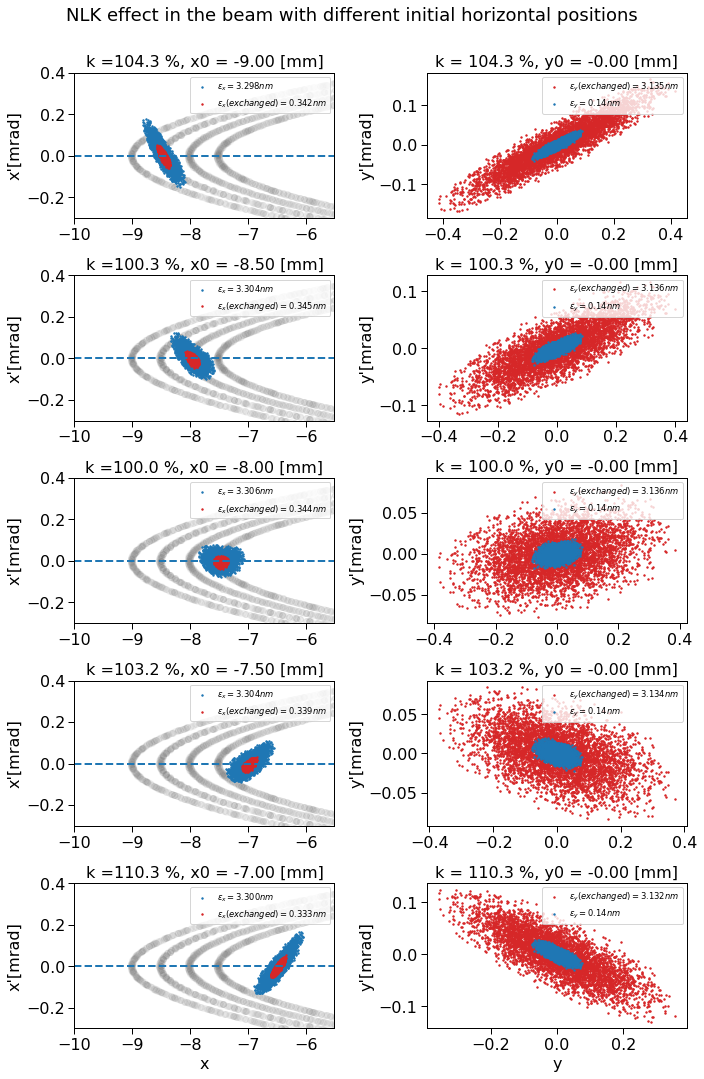

In [149]:
fig, ax = plt.subplots(x_list.size, 2, figsize=(10,15))

for i in range(ax.shape[0]):
    bunch = bunchs_after[i]
    bunchex = bunchsex_after[i]
    x_0 = bunchs_before[i, 0, :].mean()
    y_0 = bunchs_before[i, 2, :].mean()
    emitx, emity = compute_emittances(bunch, twi[nlk_idx[0][0]+1])
    emitx_ex, emity_ex = compute_emittances(bunchex, twi[nlk_idx[0][0]+1])
    
    # Plotting the results
    ax[i][0].scatter(apert[0]*1e3, apert[1]*1e3, alpha=0.05, c='tab:gray')
    ax[i][0].set_xlim([-10, -5.5])
    ax[i][0].set_ylim([-0.3, 0.4])
    ax[i][1].scatter(apert[2]*1e3, apert[3]*1e3, alpha=0.05, c='tab:gray')
    
    x, x_ = bunch[0, :]*1e3, bunch[1, :]*1e3
    y, y_ = bunch[2, :]*1e3, bunch[3, :]*1e3
    x_ex, x__ex = bunchex[0, :]*1e3, bunchex[1, :]*1e3
    y_ex, y__ex = bunchex[2, :]*1e3, bunchex[3, :]*1e3

    ax[i][0].scatter(x, x_, s=2, label=r'$\epsilon_x = {:.3f} nm$'.format(emitx*1e9), alpha=1, color='tab:blue')
    ax[i][0].scatter(x_ex, x__ex, s=2, label=r'$\epsilon_x (exchanged) = {:.3f} nm$'.format(emitx_ex*1e9), 
                  color='tab:red', alpha=1)
    ax[i][1].scatter(y_ex, y__ex, s=2, label=r'$\epsilon_y (exchanged) = {:.3f} nm$'.format(emity_ex*1e9),
                  color='tab:red', alpha=1)
    ax[i][1].scatter(y, y_, s=2, label=r'$\epsilon_y = {:.2f} nm$'.format(emity*1e9), alpha=1, color='tab:blue')
    ax[i][0].legend(loc='upper right', fontsize='small')
    ax[i][1].legend(loc='upper right', fontsize='small')
    ax[i][0].set_title(f'k ={ks_normalized[i]*100:.1f} %, x0 = {x_0*1e3:.2f} [mm]')
    ax[i][1].set_title(f'k = {ks_normalized[i]*100:.1f} %, y0 = {y_0*1e3:.2f} [mm]')
    ax[i][0].axhline(0, ls='dashed')
    ax[i][0].set_ylabel("x'[mrad]")
    ax[i][1].set_ylabel("y'[mrad]")

ax[i][0].set_xlabel('x')
ax[i][1].set_xlabel('y')
fig.suptitle("NLK effect in the beam with different initial horizontal positions", fontsize=18, y=1)
plt.tight_layout(pad=1.5)
plt.savefig('figures/TS_effects_on_exchange/NLK_effect.png', facecolor='white', transparent=False, dpi=300)